In [1]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_context("notebook", font_scale=1)
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.family'] = 'Nimbus Sans'

%matplotlib inline
%config InlineBackend.figure_formats = ['retina']

In [2]:
def combine_chip_wgbs_window_averages(chip, wgbs):
    chip_df = pd.read_csv(chip, sep="\t", index_col=0, 
                          header=None, usecols=[0,4])
    wgbs_df = pd.read_csv(wgbs, sep="\t", index_col=0,
                          header=None, usecols=[3,4]).replace(".", np.nan).astype(float)
    chip_wgbs_df = pd.concat([chip_df, wgbs_df], axis=1).dropna()
    chip_wgbs_df.columns = ["ChIP", "mCAC"]    
    return chip_wgbs_df

In [3]:
def concat_chip_mCAC(dfs, chip_columns, mCAC_columns, bins=100):
    df = pd.concat(dfs, axis=1).drop(mCAC_columns[1:], axis=1).dropna()
    df["ChIP mean"] = df[chip_columns].mean(axis=1)
    df = df.drop(chip_columns, axis=1)
    df["mCAC bins"] = pd.qcut(df[mCAC_columns[0]], bins, duplicates="drop")
    return df

In [4]:
def mean_std_err(df, groupby="mCAC bins"):
    mean = df.groupby(groupby).mean()
    std = df.groupby(groupby).sem()
    return mean, std

def plot(ax, df, groupby="mCAC bins"):
    mean, std = mean_std_err(df, groupby=groupby)    
    ax.errorbar(x=mean["{} 0".format(groupby.split(" bins")[0])].values,
                y=mean["ChIP mean"].values,
                xerr=std["{} 0".format(groupby.split(" bins")[0])].values,
                yerr=std["ChIP mean"].values,
                fmt="o", color="black", markersize=4, alpha=0.25)
    r = mean.corr(method="spearman").values[0][1]
    ax.axhline(y=0, color="black", linestyle="dashed", linewidth=1)
    ax.set_xlabel("mean mCAC")
    ax.text(0.05, 0.95, r"bins $\mathregular{R^2}=$"+"{:.2f}".format(r*r), transform=ax.transAxes, va='top')

# 3. Analysis

## 3.1 Cortex

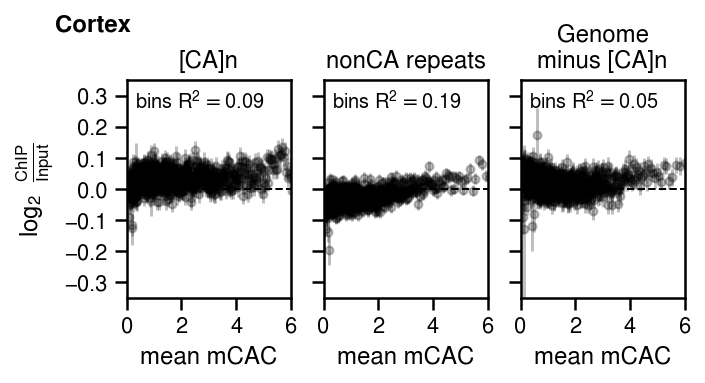

In [5]:
locis = ["CAn_1kb", "except_CAn_1kb", "1kb_subtract_CAn"]
samples = [i.split("/")[-1].rpartition(".bw")[0] for i in glob.glob("data/GSE67293_DNA_mapping/deepTools_ChIP/bamCompare/*.bw")]

fig, axes = plt.subplots(1, 3, figsize=(5,2), sharex=True, sharey=True)
for loci, ax, name in zip(locis, axes, ["[CA]n", "nonCA repeats", "Genome\nminus [CA]n"]):
    dfs = []
    chip_columns, mCAC_columns = [], []
    for n, sample in enumerate(samples):
        c = f"window_averages/GSE67293/{sample}.mm9.{loci}.tsv"
        m = f"window_averages/wgbs/lister_CAC.mm9.{loci}.tsv"
        df = combine_chip_wgbs_window_averages(c, m)
        df.columns = [f"ChIP {n}", f"mCAC {n}"]
        chip_columns.append(f"ChIP {n}")
        mCAC_columns.append(f"mCAC {n}")
        dfs.append(df)
    bins_df = concat_chip_mCAC(dfs, chip_columns, mCAC_columns, bins=1000)        
    plot(ax, bins_df)
    ax.set_title(name)
axes[0].set_xlim(0, 6)
axes[0].set_yticks([-.3, -.2, -.1, 0, .1, .2, .3])
axes[0].set_xticks([0, 2, 4, 6])
axes[0].set_ylabel(r"$\mathregular{log_2}$" "  "  r"$\mathregular{\frac{ChIP}{Input}}$")
_ = axes[0].text(0.025, 1.05, "Cortex", fontweight="bold",
                transform=fig.transFigure, fontsize="large")
_ = axes[0].set_ylim(-.35, .35)
fig.savefig("plots/cortex.pdf")

## 3.2 Forebrain

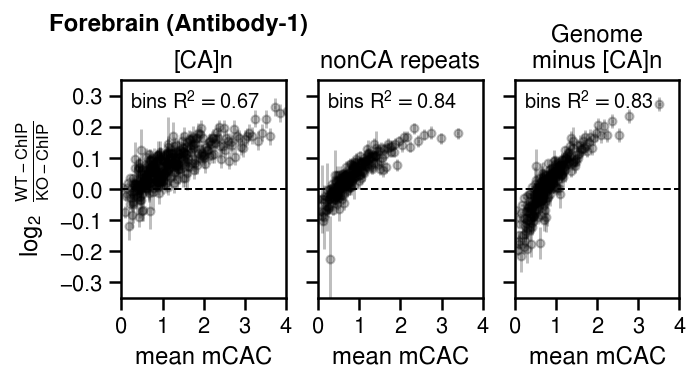

In [6]:
samples = ["SRR10356997.filtered.log2ratio.over_SRR10356999",
           "SRR10356998.filtered.log2ratio.over_SRR10357000"]

fig, axes = plt.subplots(1, 3, figsize=(5,2), sharex=True, sharey=True)
for loci, ax, name in zip(locis, axes, ["[CA]n", "nonCA repeats", "Genome\nminus [CA]n"]):
    dfs = []
    chip_columns, mCAC_columns = [], []
    for n, sample in enumerate(samples):
        c = f"window_averages/GSE139509/{sample}.mm10.{loci}.tsv"
        m = f"window_averages/wgbs/boxer_CAC.mm10.{loci}.tsv"
        df = combine_chip_wgbs_window_averages(c, m)
        df.columns = [f"ChIP {n}", f"mCAC {n}"]
        chip_columns.append(f"ChIP {n}")
        mCAC_columns.append(f"mCAC {n}")
        dfs.append(df)
    bins_df = concat_chip_mCAC(dfs, chip_columns, mCAC_columns, bins=1000)        
    plot(ax, bins_df)
    ax.set_title(name)
axes[0].set_xticks([0, 1, 2, 3, 4])
axes[0].set_yticks([-.3, -.2, -.1, 0, .1, .2, .3])
axes[0].set_xlim(0, 4)
axes[0].set_ylabel(r"$\mathregular{log_2}$" "  "  r"$\mathregular{\frac{WT-ChIP}{KO-ChIP}}$")
_ = axes[0].text(0.025, 1.05, "Forebrain (Antibody-1)", fontweight="bold",
                transform=fig.transFigure, fontsize="large")
_ = axes[0].set_ylim(-.35, .35)
fig.savefig("plots/forebrain_ab1.pdf")

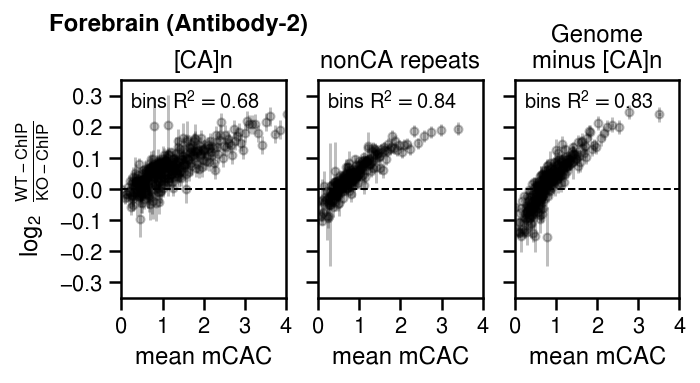

In [7]:
samples = ["SRR10357001.filtered.log2ratio.over_SRR10357003",
           "SRR10357002.filtered.log2ratio.over_SRR10357004"]
fig, axes = plt.subplots(1, 3, figsize=(5,2), sharex=True, sharey=True)
for loci, ax, name in zip(locis, axes, ["[CA]n", "nonCA repeats", "Genome\nminus [CA]n"]):
    dfs = []
    chip_columns, mCAC_columns = [], []
    for n, sample in enumerate(samples):
        c = f"window_averages/GSE139509/{sample}.mm10.{loci}.tsv"
        m = f"window_averages/wgbs/boxer_CAC.mm10.{loci}.tsv"
        df = combine_chip_wgbs_window_averages(c, m)
        df.columns = [f"ChIP {n}", f"mCAC {n}"]
        chip_columns.append(f"ChIP {n}")
        mCAC_columns.append(f"mCAC {n}")
        dfs.append(df)
    bins_df = concat_chip_mCAC(dfs, chip_columns, mCAC_columns, bins=1000)        
    plot(ax, bins_df)
    ax.set_title(name)
axes[0].set_xticks([0, 1, 2, 3, 4])
axes[0].set_xlim(0, 4)
axes[0].set_yticks([-.3, -.2, -.1, 0, .1, .2, .3])
axes[0].set_ylabel(r"$\mathregular{log_2}$" "  "  r"$\mathregular{\frac{WT-ChIP}{KO-ChIP}}$")
_ = axes[0].text(0.025, 1.05, "Forebrain (Antibody-2)", fontweight="bold",
                transform=fig.transFigure, fontsize="large")
_ = axes[0].set_ylim(-.35, .35)
fig.savefig("plots/forebrain_ab2.pdf")

## 3.3 Hypothalamus

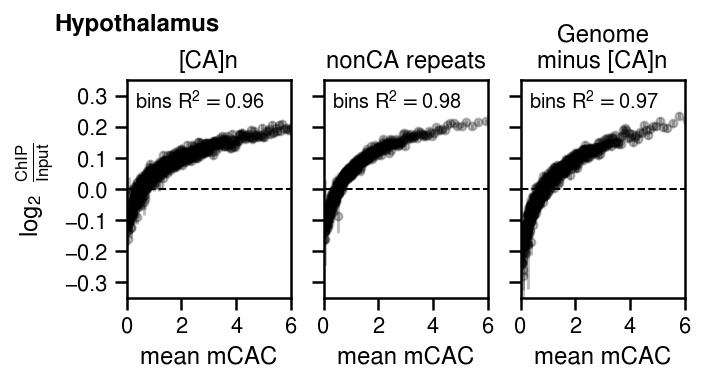

In [8]:
samples = [i.split("/")[-1].rpartition(".bw")[0] for i in glob.glob("data/GSE66868_DNA_mapping/deepTools_ChIP/bamCompare/*.bw")]

fig, axes = plt.subplots(1, 3, figsize=(5,2), sharex=True, sharey=True)
for loci, ax, name in zip(locis, axes, ["[CA]n", "nonCA repeats", "Genome\nminus [CA]n"]):
    dfs = []
    chip_columns, mCAC_columns = [], []
    for n, sample in enumerate(samples):
        c = f"window_averages/GSE66868/{sample}.mm9.{loci}.tsv"
        m = f"window_averages/wgbs/lagger_CAC.mm9.{loci}.tsv"
        df = combine_chip_wgbs_window_averages(c, m)
        df.columns = [f"ChIP {n}", f"mCAC {n}"]
        chip_columns.append(f"ChIP {n}")
        mCAC_columns.append(f"mCAC {n}")
        dfs.append(df)
    bins_df = concat_chip_mCAC(dfs, chip_columns, mCAC_columns, bins=1000)        
    plot(ax, bins_df)
    ax.set_title(name)
axes[0].set_xticks([0, 2, 4, 6])
axes[0].set_yticks([-.3, -.2, -.1, 0, .1, .2, .3])
axes[0].set_xlim(0, 6)
axes[0].set_ylabel(r"$\mathregular{log_2}$" "  "  r"$\mathregular{\frac{ChIP}{Input}}$")
_ = axes[0].text(0.025, 1.05, "Hypothalamus", fontweight="bold",
                transform=fig.transFigure, fontsize="large")
_ = axes[0].set_ylim(-.35, .35)
fig.savefig("plots/hypothalamus.pdf")

# 4. No. of MACS2 peaks

In [1]:
# Forebrain
!bedtools merge -i <(cat data/GSE139509_DNA_mapping/MACS2/SRR10356997.filtered.BAM_peaks.narrowPeak data/GSE139509_DNA_mapping/MACS2/SRR10356998.filtered.BAM_peaks.narrowPeak | sort -k1,1 -k2,2n) | wc -l

# Hypothalamus
!bedtools merge -i <(cat data/GSE66868_DNA_mapping/MACS2/*.narrowPeak | sort -k1,1 -k2,2n) | wc -l

# Frontal cortex
!bedtools merge -i <(cat data/GSE67293_DNA_mapping/MACS2/*.narrowPeak | sort -k1,1 -k2,2n) | wc -l

271334
236330
37817
